In [ ]:
! unzip /content/drive/MyDrive/datasets/clean_trainset_28spk_wav.zip
! unzip /content/drive/MyDrive/datasets/clean_testset_wav.zip
! unzip /content/drive/MyDrive/datasets/noisy_testset_wav.zip
! unzip /content/drive/MyDrive/datasets/noisy_trainset_28spk_wav.zip
! unzip /content/drive/MyDrive/datasets/logfiles.zip

Streaming output truncated to the last 5000 lines.
  inflating: noisy_trainset_28spk_wav/p268_010.wav  
  inflating: noisy_trainset_28spk_wav/p268_011.wav  
  inflating: noisy_trainset_28spk_wav/p268_012.wav  
  inflating: noisy_trainset_28spk_wav/p268_013.wav  
  inflating: noisy_trainset_28spk_wav/p268_014.wav  
  inflating: noisy_trainset_28spk_wav/p268_015.wav  
  inflating: noisy_trainset_28spk_wav/p268_016.wav  
  inflating: noisy_trainset_28spk_wav/p268_017.wav  
  inflating: noisy_trainset_28spk_wav/p268_018.wav  
  inflating: noisy_trainset_28spk_wav/p268_019.wav  
  inflating: noisy_trainset_28spk_wav/p268_020.wav  
  inflating: noisy_trainset_28spk_wav/p268_021.wav  
  inflating: noisy_trainset_28spk_wav/p268_022.wav  
  inflating: noisy_trainset_28spk_wav/p268_024.wav  
  inflating: noisy_trainset_28spk_wav/p268_025.wav  
  inflating: noisy_trainset_28spk_wav/p268_026.wav  
  inflating: noisy_trainset_28spk_wav/p268_027.wav  
  inflating: noisy_trainset_28spk_wav/p268_028.w

In [ ]:
! pip install wavinfo
! sudo apt install sox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 631 kB 8.3 MB/s 
     |████████████████████████████████| 60 kB 8.9 MB/s 
     |████████████████████████████████| 109 kB 59.2 MB/s 
     |████████████████████████████████| 546 kB 49.6 MB/s 
  Created wheel for ear: filename=ear-2.1.0-py3-none-any.whl size=668352 sha256=8cb385429fee26f2d3aaa4f2d0ea4004c70038407a9b32e2941c96bbd3ba118c
  Stored in directory: /root/.cache/pip/wheels/07/70/1e/67526c82388980847f2c15ea93273759428af4107715b642ac
Successfully built ear
  Attempting uninstall: attrs
    Found existing installation: attrs 22.1.0
    Uninstalling attrs-22.1.0:
      Successfully uninstalled attrs-22.1.0
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The follow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
import subprocess
import glob
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
import librosa
from keras.layers import BatchNormalization,Dropout,Dense,Input,LeakyReLU
from keras import backend as K
from keras.callbacks import ModelCheckpoint,TensorBoard
from keras.models import Model
from keras.initializers import he_normal
from keras.models import model_from_json
from keras import optimizers

## PreProcessing

In [ ]:
fft_size = 512
step_size = fft_size // 3 # distance to slide along the window

# fequency to mel parameter #
n_mels = 40 # number of mel frequency
start_freq = 0.0
end_freq = 8000.0

In [ ]:
import librosa

In [ ]:
def stft(data, fft_size, step_size):
    # short time fourier transform
    window = np.hamming(fft_size)
    win_num = (len(data) - 2 * fft_size) // step_size
    out = np.ndarray((win_num, fft_size), dtype=data.dtype)
    for i in range(win_num):
        left = int(i * step_size)
        right = int(left + fft_size)
        out[i] = data[left: right] * window
    F = np.fft.rfft(out, axis=1)
    return F

def istft(F, fft_size, step_size):
    # inverse short time fourier transform
    data = np.fft.irfft(F, axis=-1)
    window = np.hamming(fft_size)
    number_windows = F.shape[0]
    T = np.zeros((number_windows * step_size + fft_size))
    for i in range(number_windows):
        head = int(i * step_size)
        tail = int(head + fft_size)
        T[head:tail] = T[head:tail] + data[i, :] * window
    return T

# combine FFT bins to mel frequency bins
def mel2freq(mel_data,sr,fft_size,n_mel,fmax=8000):
    matrix= librosa.filters.mel(sr, fft_size, n_mel, fmax=fmax)
    return np.dot(mel_data,matrix)

def freq2mel(f_data,sr,fft_size,n_mel,fmax=8000):
    pre_matrix = librosa.filters.mel(sr, fft_size, n_mel, fmax=fmax)
    matrix = pre_matrix.T / np.sum(pre_matrix.T,axis=0)
    return np.dot(f_data,matrix)

# directly time to mel domain transformation
def time_to_mel(data,sr,fft_size,n_mel,step_size,fmax=8000):
    F = stft(data,fft_size,step_size)
    M = freq2mel(F,sr,fft_size,n_mel,fmax=8000)
    return M

def mel_to_time(M,sr,fft_size,n_mel,step_size,fmax=8000):
    F = mel2freq(M,sr,fft_size,n_mel)
    T = istft(F,fft_size,step_size)
    return T

def real_imag_expand(mel_data):
    # expand the complex data to 2X data with true real and image number
    D = np.zeros((mel_data.shape[0],mel_data.shape[1]*2))
    D[:,::2] = np.real(mel_data)
    D[:,1::2] = np.imag(mel_data)
    return D

# normalization function
def min_max_norm(x):
    # x should be numpy M*N matrix , normalize the N axis
    return (x-np.min(x,axis=0)) / (np.max(x,axis=0)-np.min(x,axis=0))


In [ ]:
D_X = np.empty((0,n_mels*2))
D_y = np.empty((0,n_mels*2))
count = 0
c=0
for i in os.listdir("/content/clean_trainset_28spk_wav/")[0:1000]:
    clean_data, clean_sr = librosa.load('/content/clean_trainset_28spk_wav/'+i, sr=16000)  # time series data,sample rate
    mel_clean_data = time_to_mel(clean_data,clean_sr,fft_size,n_mels,step_size,fmax=8000)
    a = real_imag_expand(mel_clean_data)
    D_y=np.vstack((D_y,a))
    np.save("Clean_trainset_0-1000.npy",D_y)
    count = count+1
    print(count)
for i in os.listdir("/content/noisy_trainset_28spk_wav/")[0:1000]:
    mix_data, mix_sr = librosa.load('/content/noisy_trainset_28spk_wav/'+i, sr=16000)  # time series data,sample rate
    mel_mix_data = time_to_mel(mix_data,mix_sr,fft_size,n_mels,step_size)
    b = real_imag_expand(mel_mix_data)
    D_X=np.vstack((D_X,b))
    np.save("Noisy_trainset_0-1000.npy",D_X)
    c = c+1
    print(c)
# separate data to train test sets
D_X_train = min_max_norm(D_X[:int(D_X.shape[0]*0.9),:])
D_y_train = D_y[:int(D_y.shape[0]*0.9),:] / D_X[:int(D_X.shape[0]*0.9),:]
G_max = np.max(D_y_train)
D_y_train = D_y_train/G_max

X_test = min_max_norm(D_X[int(D_X.shape[0]*0.9):,:])
y_test = D_y[int(D_y.shape[0]*0.9):,:] / D_X[int(D_X.shape[0]*0.9):,:]
y_test = y_test/G_max

X_train, X_val, y_train, y_val = train_test_split(D_X_train, D_y_train, test_size=0.15, random_state=87)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
n_input_dim = X_train.shape[1]
n_output_dim = y_train.shape[1]

n_hidden1 = 2049
n_hidden2 = 500
n_hidden3 = 180

InputLayer1 = Input(shape=(n_input_dim,), name="InputLayer")
InputLayer2 = BatchNormalization(axis=1, momentum=0.6)(InputLayer1)

HiddenLayer1_1 = Dense(n_hidden1, name="H1", activation='relu', kernel_initializer=he_normal(seed=27))(InputLayer2)
HiddenLayer1_2 = BatchNormalization(axis=1, momentum=0.6)(HiddenLayer1_1)
HiddenLayer1_3 = Dropout(0.1)(HiddenLayer1_2)

HiddenLayer2_1 = Dense(n_hidden2, name="H2", activation='relu', kernel_initializer=he_normal(seed=42))(HiddenLayer1_3)
HiddenLayer2_2 = BatchNormalization(axis=1, momentum=0.6)(HiddenLayer2_1)

HiddenLayer3_1 = Dense(n_hidden3, name="H3", activation='relu', kernel_initializer=he_normal(seed=65))(HiddenLayer2_2)
HiddenLayer3_2 = BatchNormalization(axis=1, momentum=0.6)(HiddenLayer3_1)

HiddenLayer2__1 = Dense(n_hidden2, name="H2_R", activation='relu', kernel_initializer=he_normal(seed=42))(HiddenLayer3_2)
HiddenLayer2__2 = BatchNormalization(axis=1, momentum=0.6)(HiddenLayer2__1)

HiddenLayer1__1 = Dense(n_hidden1, name="H1_R", activation='relu', kernel_initializer=he_normal(seed=27))(HiddenLayer2__2)
HiddenLayer1__2 = BatchNormalization(axis=1, momentum=0.6)(HiddenLayer1__1)
HiddenLayer1__3 = Dropout(0.1)(HiddenLayer1__2)

OutputLayer = Dense(n_output_dim, name="OutputLayer", kernel_initializer=he_normal(seed=62))(HiddenLayer1__3)

model = Model(inputs=[InputLayer1], outputs=[OutputLayer])
opt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0001, amsgrad=False)
    # loss = p_loss(OutputLayer,K.placeholder())
model.compile(loss='mse', optimizer=opt)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()
    # fit the model
hist = model.fit(X_train, y_train, batch_size=512, epochs=20, verbose=1, validation_data=([X_val], [y_val]))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 80)]              0         
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 H1 (Dense)                  (None, 2049)              165969    
                                                                 
 batch_normalization_1 (Batc  (None, 2049)             8196      
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 2049)              0         
                                                                 
 H2 (Dense)                  (None, 500)               102500

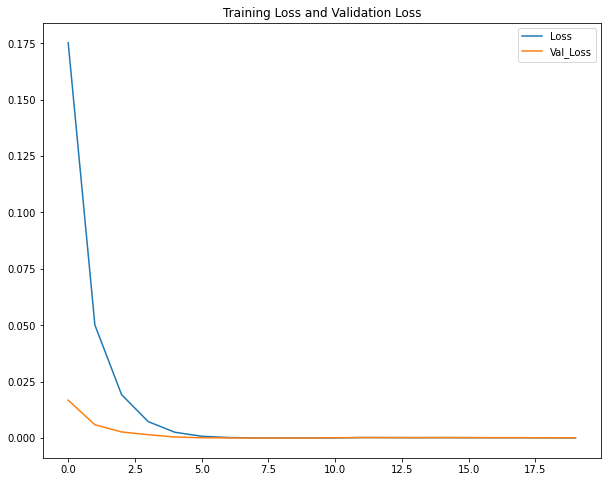

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(hist.history['loss'], label='Loss')
plt.plot(hist.history['val_loss'], label='Val_Loss')
plt.legend(loc='best')
plt.title('Training Loss and Validation Loss')
plt.show()

In [ ]:
results = model.evaluate(X_test, y_test, batch_size=len(y_test))
print('Test loss:%3f' % results)

1/1 [==============================] - 3s 3s/step - loss: 0.0017
Test loss:0.001688


In [ ]:
model.save("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
import keras
import scipy.io.wavfile as wavfile
def denoise(input_path,model_path,output_path):   
    denoise_model=keras.models.load_model(model_path)

    mix_data, mix_sr = librosa.load(input_path, sr=16000)  
    mel_mix_data = time_to_mel(mix_data,mix_sr,fft_size,n_mels,step_size)
    D_X = real_imag_expand(mel_mix_data)

    gain = denoise_model.predict(D_X) * G_max
    M_gain = gain[:,::2]+1j*gain[:,1::2]
    F_gain = mel2freq(M_gain,mix_sr,fft_size,n_mels)

    F = F_gain * stft(mix_data,fft_size,step_size)
    #ratio[np.isnan(ratio)] = 0.0
    print("shape of F_out:",F.shape)
    T = istft(F,fft_size,step_size)

    # write the result
    Tint = T/np.max(T)*32767
    wavfile.write(output_path,mix_sr,Tint.astype('int16'))

In [ ]:
denoise("/content/noisy_testset_wav/p232_001.wav","/content/model.h5","/content/denoised-cnn/p232_001_denoised.wav")

shape of F_out: (157, 257)


In [ ]:
for i in os.listdir("/content/noisy_testset_wav/"):
    denoise("/content/noisy_testset_wav/"+i,"/content/model.h5","/content/drive/MyDrive/denoised-cnn/denoised_"+i)

shape of F_out: (362, 257)
shape of F_out: (277, 257)
shape of F_out: (222, 257)
shape of F_out: (244, 257)
shape of F_out: (230, 257)
shape of F_out: (175, 257)
shape of F_out: (179, 257)
shape of F_out: (342, 257)
shape of F_out: (205, 257)
shape of F_out: (254, 257)
shape of F_out: (196, 257)
shape of F_out: (248, 257)
shape of F_out: (282, 257)
shape of F_out: (145, 257)
shape of F_out: (251, 257)
shape of F_out: (310, 257)
shape of F_out: (212, 257)
shape of F_out: (208, 257)
shape of F_out: (258, 257)
shape of F_out: (260, 257)
shape of F_out: (120, 257)
shape of F_out: (234, 257)
shape of F_out: (237, 257)
shape of F_out: (319, 257)
shape of F_out: (175, 257)
shape of F_out: (177, 257)
shape of F_out: (189, 257)
shape of F_out: (188, 257)
shape of F_out: (313, 257)
shape of F_out: (252, 257)
shape of F_out: (169, 257)
shape of F_out: (255, 257)
shape of F_out: (231, 257)
shape of F_out: (203, 257)
shape of F_out: (331, 257)
shape of F_out: (304, 257)
shape of F_out: (217, 257)
s

In [ ]:
! pip install pesq
! pip install pystoi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pesq: filename=pesq-0.0.4-cp37-cp37m-linux_x86_64.whl size=214594 sha256=e1bd1089f0d5ea056a4566efb0db106b913d38236a2b8ad284126236afd4f9ed
  Stored in directory: /root/.cache/pip/wheels/c5/3d/9c/542731f8357f7c82eb6ac2047cc5375f92c9a05b09a715aff6
Successfully built pesq
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pystoi: filename=pystoi-0.3.3-py2.py3-none-any.whl size=7793 sha256=c1e11ee2c4629069eb28ba4095680db96966b2737459f724c9255d1c32fc467e
  Stored in directory: /root/.cache/pip/wheels/46/4a/ad/3ab460193ed0535430b4b1575f255aa6bae69df17453628e86
Successfully built pystoi


In [ ]:
from pesq import pesq
from pystoi import stoi
if __name__ == '__main__':
    
    #df = pd.read_csv("16khz_Bixy_Denosing_NSnet.csv")
    #csl=df["Clean"]
    #esl = df["Denoised"]
    
    clean=[]
    enhance=[]
    
    pesq_wb=[]
    pesq_nb=[]
    stoi_eval=[]
    for i  in os.listdir("/content/drive/MyDrive/denoised/"):
        original="/content/clean_testset_wav/"+i.split('_')[1]+"_"+i.split("_")[2]
        #spl=i.split('_')[0]
        print(original)
        
        reconstructed="/content/drive/MyDrive/denoised/"+i
        #reconstructed=i
        try:
            rate,ref = wavfile.read(original)
            rate,deg = wavfile.read(reconstructed)
        
            if ref.shape < deg.shape:
                deg=deg[:ref.shape[0]]
            else:
                ref=ref[:deg.shape[0]]
            print('ref = ',ref.shape)
            print('def = ',deg.shape)
            print(i)
            print(rate)
            print(pesq(rate, ref, deg, 'wb'))
            #print(pesq(rate, ref, deg, 'nb'))
            print(stoi(ref, deg, rate, extended=False))
        except:
            print("Problem with file")
            continue
        #signal_noise_ratio.append(SNR)
        try:
            pesq_nb.append(pesq(rate, ref, deg, 'nb'))
            clean.append(original)
            enhance.append(reconstructed)
            pesq_wb.append(pesq(rate, ref, deg, 'wb'))
            stoi_eval.append(stoi(ref, deg, rate, extended=False))
        except:
            print("Problem with file")
            continue
    df=pd.DataFrame([clean,enhance,pesq_wb,pesq_nb,stoi_eval])
    g=np.array(df).T
    g=pd.DataFrame(g,columns=['Clean_speech_file','Enhance_speech_file', 'PESQ_Wide_band','PESQ_narrow_band','STOI'])
    g.to_csv('pesq_stoi_VCTK_result_data_autoencoder.csv',index=False)
    
    print('Average PESQ Wide Band: ', np.mean(g['PESQ_Wide_band']))
    print('Average PESQ Narrow Band: ', np.mean(g['PESQ_narrow_band']))
    print('Average STOI: ',np.mean(g['STOI']))

Streaming output truncated to the last 5000 lines.
1.5083413124084473
0.1821593933261514
/content/clean_testset_wav/p232_351.wav
ref =  (29242,)
def =  (29242,)
denoised_p232_351.wav
16000
Problem with file
/content/clean_testset_wav/p232_223.wav
ref =  (39612,)
def =  (39612,)
denoised_p232_223.wav
16000
1.3608195781707764
0.10476826594915944
/content/clean_testset_wav/p257_182.wav
ref =  (36042,)
def =  (36042,)
denoised_p257_182.wav
16000
1.0878514051437378
0.10436341753426051
/content/clean_testset_wav/p257_120.wav
ref =  (21932,)
def =  (21932,)
denoised_p257_120.wav
16000
1.0690369606018066
0.22675415380187494
/content/clean_testset_wav/p232_153.wav
ref =  (30262,)
def =  (30262,)
denoised_p232_153.wav
16000
1.1740293502807617
0.08404070576684845
/content/clean_testset_wav/p257_317.wav
ref =  (27372,)
def =  (27372,)
denoised_p257_317.wav
16000
1.1136666536331177
-0.014704831020048244
/content/clean_testset_wav/p232_167.wav
ref =  (42332,)
def =  (42332,)
denoised_p232_167.wav
16

In [ ]:
cp /content/drive/MyDrive/denoised/denoised_p257_232.wav .